In [48]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images, add_average_velocity

from src.utils.utils import add_spatial_encoding, gaussian_density
from src.utils.node import train, BatchGetterMultiTrajectories
from src.utils.viz import plot_tsne_and_pca, plot_tsne_and_pca_portrait, display_ode_trajectory

from src.models.ae import ConvAE
from src.models.node import ODEnetSimple
from src.models.anode import ANODENet

In [2]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}


In [3]:
x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)

In [55]:
Num_pos_velocity = 1
N = 300
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)

images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float()
print(images.shape)

100%|██████████| 300/300 [00:09<00:00, 33.04it/s]


(90300, 1, 28, 28)
torch.Size([90300, 3, 28, 28])


In [56]:
latent_dim_model = 25
activation = "ReLU"
activation_fn = getattr(torch.nn, activation)
# path = "models/AE/ae_1_Ball_with_sp_latent_{}.pth".format(latent_dim)
# path = "models/AE/ae_1_Ball_with_sp_latent_{}_no_relu.pth".format(latent_dim)
# Good: SiLU with 10 latent dim, GELU with 6 latent dim
path = "models/AE/AE_with_smooth_activation/ae_1_Ball_with_sp_latent_{}_no_relu_activation_{}_no_margin.pth".format(latent_dim_model, activation)

ae = ConvAE(height=HEIGHT, width=WIDTH, in_channels=3, latent_dim=latent_dim_model, relu=False, activation=activation_fn)
print(ae.load_state_dict(torch.load(path)))

for param in ae.parameters():
    param.requires_grad = False

encoded_trajectory = ae.encode(images).reshape(N, N_frames, latent_dim_model).detach()
print(encoded_trajectory.shape)
print(images.shape)
images = images.reshape(N, N_frames, 3, HEIGHT, WIDTH)[:, :N_frames - Num_pos_velocity,...]
print(images.shape)

Number of parameters in the model: 276028
<All keys matched successfully>
torch.Size([300, 301, 25])
torch.Size([90300, 3, 28, 28])
torch.Size([300, 300, 3, 28, 28])


In [57]:
# prepare data to contains positions and velocity
print(encoded_trajectory.shape)
encoded_trajectory = add_average_velocity(encoded_trajectory, Num_pos_velocity, dt)
print(encoded_trajectory.shape)

torch.Size([300, 301, 25])
torch.Size([300, 300, 50])


In [58]:
batch_time = 100
n_samples = 1
total_length = N_frames - Num_pos_velocity


class BatchGetterMultiTrajectoriesWithImages:
    def __init__(self, batch_time, n_samples, total_length, dt, positions, images, frac_train):
        # N: number of trajectories
        # M: number of time steps
        # D: dimension of the state space
        # positions: (N, T, D)
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        if isinstance(positions, torch.Tensor):
            self.true_positions = positions.float()

        elif isinstance(positions, np.ndarray):
            self.true_positions = torch.from_numpy(positions).float()

        else:
            assert False, "positions must be either a torch.Tensor or a np.ndarray"

        self.N_train = int(positions.shape[0]*frac_train)

        self.train_times = self.times #[:self.N_train]
        self.test_times = self.times #[self.N_train:]
        self.train_positions = self.true_positions[:self.N_train]
        self.test_positions = self.true_positions[self.N_train:]
        self.train_images = images[:self.N_train]
        self.test_images = images[self.N_train:]
        self.n_samples = n_samples
        self.batch_time = batch_time
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        index = np.random.randint(0, self.N_train, self.n_samples)
        s = torch.from_numpy(np.random.choice(np.arange(self.train_times.shape[0] - self.batch_time, dtype=np.int64), self.n_samples, replace=False))
        batch_y0 = self.train_positions[index, s]  # (M, D)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_images = torch.stack([self.train_images[index, s + i] for i in range(self.batch_time)], dim=0).squeeze(1) # (T, M, D)
        return batch_y0, batch_t, batch_images


getter = BatchGetterMultiTrajectoriesWithImages(batch_time, n_samples, total_length, dt, encoded_trajectory, images, frac_train=1.)

In [78]:
latent_dim = latent_dim_model*(1 + 1)
device = "cpu"
data_dim = latent_dim
hidden_dim = 128
output_dim = latent_dim
augment_dim = 0
anode = ANODENet(device, data_dim, hidden_dim, output_dim, augment_dim, time_dependent=False)
# pathModel = "models/AE_ODE/MultiTrajectories/anode_1_Ball_with_sp_latent_25_velocity_1_hidden_dim_128_no_relu_activation_ReLU_no_margin.pth"
# anode.load_state_dict(torch.load(pathModel))

The graphs at epoch 0


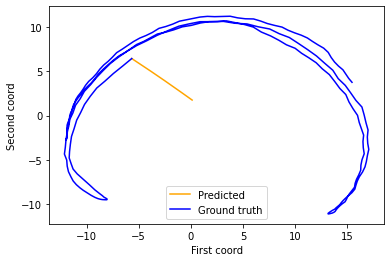

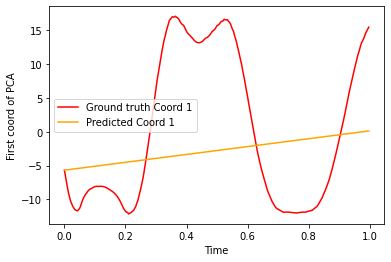

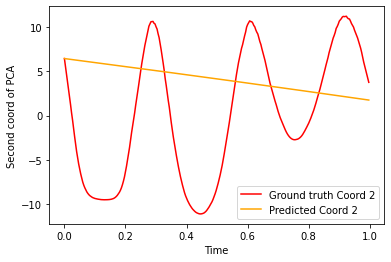

In [79]:
display_ode_trajectory(0, anode, latent_dim_model, getter, final_time=total_length, dt=dt)

In [133]:
optimizer = torch.optim.Adam(anode.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.99)
batch_size = 16
epochs = 10000

In [131]:
class loss_ODE(torch.nn.Module):
    def __init__(self, ae_model, latent_dim_model):
        super(loss_ODE, self).__init__()
        self.ae_model = ae_model
        self.ae_model.eval()
        for param in self.ae_model.parameters():
            param.requires_grad = False
        
        self.latent_dim_model = latent_dim_model

        self.loss_fn = torch.nn.MSELoss()

    def forward(self, out_latent, true_images):
        
        out_images = self.ae_model.decode(out_latent[..., :self.latent_dim_model])
        loss_images = self.loss_fn(out_images, true_images)
        # regularization
        reg_latent = torch.mean(torch.norm(out_latent[..., 0, self.latent_dim_model:], p=2, dim=-1))
        loss = loss_images + 1e-5*reg_latent
        # print(loss_images, 1e-5*reg_latent)
        return loss # loss_images, 1e-7*reg_latent

loss_fn = loss_ODE(ae, latent_dim_model)

In [132]:
batch_y0, batch_t, batch_images = getter.get_batch()
out_latent = anode(batch_y0, batch_t)
loss_images = loss_fn(out_latent, batch_images)
print(loss_images)

tensor(0.0011, grad_fn=<AddBackward0>)


In [97]:
def train(model, optimizer, scheduler, epochs, batch_size, getter, loss_fn=None, display=100, display_results_fn=display_ode_trajectory, out_display=-1):
    
    if out_display == -1:
        out_display = model.out_dim

    if loss_fn is None:
        loss_fn = nn.MSELoss()
    
    iterator = trange(1, epochs+1)
    # just for the plot part
    running_loss = 0.
    for i in iterator:
        # get a random time sample
        model.train()
        loss = 0.
        for _ in range(batch_size):
            batch_init_positions, batch_times, batch_true_images = getter.get_batch()
            # compute the output of the model
            out = model(batch_init_positions, batch_times)
            # compute the loss
            # print(out.shape, out.view(-1, batch_init_positions.shape[-1]).shape)
            # print(batch_true_positions.shape, batch_true_positions.view(-1, batch_init_positions.shape[-1]).shape)
            loss += loss_fn(out[:], batch_true_images[:])
            # .view(-1,batch_init_positions.shape[-1])
        loss /= batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update the progress bar
        iterator.set_postfix_str(f'Loss: {loss.item():.8f}')
        running_loss += loss.item()

        if i % display == 0:
           display_results_fn(i, model, out_display, getter, getter.total_length, getter.dt)
           iterator.set_description_str(f'Display loss: {running_loss/display:.8f}')
           running_loss = 0.


        scheduler.step()
        
    return None

In [ ]:
train(anode, optimizer, scheduler, epochs, batch_size, getter, loss_fn=loss_fn, 
        display=200, display_results_fn=display_ode_trajectory, out_display=latent_dim_model) 

In [138]:
torch.save(anode.state_dict(), "models/AE_ODE/MultiTrajectories/anode_1_Ball_with_sp_latent_{}_velocity_{}_hidden_dim_{}_no_relu_activation_{}_no_margin_mse_on_images.pth".format(latent_dim_model, Num_pos_velocity, hidden_dim, activation))
